### data/preprocessing.py

In [189]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

class FillMissingValues(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.median_competition_distance = X['competition_distance'].median()
        self.mode_competition_open_since_year = X['competition_open_since_year'].mode()[0]
        self.mode_competition_open_since_month = X['competition_open_since_month'].mode()[0]
        return self

    def transform(self, X, y=None):
        X = X.copy()
        X['competition_distance'].fillna(self.median_competition_distance, inplace=True)
        X['competition_open_since_year'].fillna(self.mode_competition_open_since_year, inplace=True)
        X['competition_open_since_month'].fillna(self.mode_competition_open_since_month, inplace=True)
        X['promo2_since_week'].fillna(0, inplace=True)
        X['promo2_since_year'].fillna(0, inplace=True)
        X['promo_interval'].fillna(0, inplace=True)
        return X

class EncodeScaleData(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.label_encoder = LabelEncoder()
        self.assortment_dict = {'a': 1, 'b': 2, 'c': 3}
        self.minmax_scaler = MinMaxScaler()
        self.standard_scaler = StandardScaler()
        self.ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
        self.column_transformer = None

    def fit(self, X, y=None):
        X = X.copy()
        # Fit OneHotEncoder and LabelEncoder
        self.ohe.fit(X[['state_holiday']])
        self.label_encoder.fit(X['store_type'])
        return self

    def transform(self, X, y=None):
        X = X.copy()
        # Apply OneHotEncoder to state_holiday
        state_holiday_encoded = self.ohe.transform(X[['state_holiday']])
        state_holiday_encoded_df = pd.DataFrame(state_holiday_encoded, columns=self.ohe.get_feature_names_out(['state_holiday']))

        # Apply LabelEncoder to store_type
        X['store_type'] = self.label_encoder.transform(X['store_type'])
        X['assortment'] = X['assortment'].map(self.assortment_dict)

        # Scaling numerical features
        X[['year', 'promo2_since']] = self.minmax_scaler.fit_transform(X[['year', 'promo2_since']])
        X[['competition_distance', 'competition_open']] = self.minmax_scaler.fit_transform(X[['competition_distance', 'competition_open']])
        X[['customers']] = self.standard_scaler.fit_transform(X[['customers']])

        # Drop original state_holiday column and concatenate encoded dataframe
        X = X.drop(columns=['state_holiday'])
        X = pd.concat([X.reset_index(drop=True), state_holiday_encoded_df.reset_index(drop=True)], axis=1)

        return X


### feature_engineering/feature_engineering.py

In [190]:
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
import numpy as np

class FeatureEngineering(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X.copy()
        months = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
                  7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
        X['is_promo'] = X.apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if months[x['date'].month] in x['promo_interval'].split(",") else 0, axis=1)
        X['day'] = X['date'].dt.day
        X['month'] = X['date'].dt.month  # Ensure month column is created
        X['year'] = X['date'].dt.year
        X['week_of_year'] = X['date'].dt.isocalendar().week
        X['competition_open'] = (X['year'] - X['competition_open_since_year']) * 12 - X['competition_open_since_month'] + X['month']
        X['competition_open'] = X['competition_open'].apply(lambda x: 0 if x < 0 else x)
        promo2_conditional_difference = np.where(X['promo2_since_year'] != 0, X['year'] - X['promo2_since_year'], 0)
        X['promo2_since'] = (promo2_conditional_difference) * 52 + X['week_of_year'] - X['promo2_since_week']
        X['promo2_since'] = X['promo2_since'].apply(lambda x: max(x, 0))
        X['state_holiday'] = X['state_holiday'].astype(str)
        X['store_type'] = X['store_type'].astype(str)
        X['assortment'] = X['assortment'].astype(str)

        return X

    def get_feature_names_out(self, input_features=None):
        return self.columns_.tolist()


class CyclicalFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, columns, max_values):
        self.columns = columns
        self.max_values = max_values

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X.copy()
        for column, max_value in zip(self.columns, self.max_values):
            X[column + '_sin'] = np.sin(2 * np.pi * X[column] / max_value)
            X[column + '_cos'] = np.cos(2 * np.pi * X[column] / max_value)
        return X.drop(columns=self.columns)


### feature_engineering/drop_columns.py

In [191]:
from sklearn.base import BaseEstimator, TransformerMixin

class DropColumns(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X.copy()
        return X.drop(columns=self.columns)


### model/vif_selector.py

In [192]:
from sklearn.base import BaseEstimator, TransformerMixin
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd
import numpy as np

class VIFSelector(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=5):
        self.threshold = threshold
        self.columns_ = None

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X.copy()
        
        print("Initial number of columns:", X.shape[1])  # Debug print
        
        high_vif = True
        while high_vif:
            vif_values = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
            max_vif = max(vif_values)
            print("Current max VIF:", max_vif)  # Debug print
            if max_vif > self.threshold:
                max_vif_index = vif_values.index(max_vif)
                column_to_drop = X.columns[max_vif_index]
                print("Dropping column:", column_to_drop)  # Debug print
                X = X.drop(columns=[column_to_drop])
            else:
                high_vif = False
        self.columns_ = X.columns
        print("Final number of columns:", X.shape[1])  # Debug print
        return X

    def get_feature_names_out(self, input_features=None):
        return self.columns_.tolist()


### model/select_k_best.py

In [193]:
# from sklearn.base import BaseEstimator, TransformerMixin
# from sklearn.feature_selection import SelectKBest, mutual_info_regression
# import pandas as pd

# class SelectKBestFeatures(BaseEstimator, TransformerMixin):
#     def __init__(self, k='all'):
#         self.k = k
#         self.selector = SelectKBest(score_func=mutual_info_regression, k=k)

#     def fit(self, X, y):
#         self.selector.fit(X, y)
#         self.columns_ = X.columns[self.selector.get_support()]
#         return self

#     def transform(self, X, y=None):
#         return X[self.columns_]
    
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import mutual_info_regression, SelectKBest
import pandas as pd

class SelectKBestFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, k='all', threshold=0.005):
        self.k = k
        self.threshold = threshold
        self.feature_scores_ = None  # Use trailing underscore to follow sklearn convention

    def fit(self, X, y):
        self.selector = SelectKBest(score_func=mutual_info_regression, k='all')
        self.selector.fit(X, y)
        
        # Get the scores and identify features with low mutual information
        scores = self.selector.scores_
        self.feature_scores_ = pd.DataFrame({'feature': X.columns, 'score': scores})
        self.columns_ = self.feature_scores_[self.feature_scores_['score'] > self.threshold]['feature'].values
        
        return self

    def transform(self, X, y=None):
        return X[self.columns_]

    def get_feature_names_out(self, input_features=None):
        return self.columns_

    def get_feature_scores(self):
        return self.feature_scores_


### app/pipeline.py

In [194]:
from sklearn.pipeline import Pipeline
# from data.preprocessing import FillMissingValues, EncodeScaleData
# from feature_engineering.feature_engineering import FeatureEngineering, CyclicalFeatures
# from feature_engineering.drop_columns import DropColumns
# from model.vif_selector import VIFSelector
# from model.select_k_best import SelectKBestFeatures
from sklearn.linear_model import LinearRegression
from sklearn.base import BaseEstimator, TransformerMixin

class ConvertToFloat64(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X.astype('float64')

def create_pipeline():
    preprocessing_pipeline = Pipeline(steps=[
        ('fill_missing', FillMissingValues()),
        ('feature_engineering', FeatureEngineering()),
        ('cyclical_features', CyclicalFeatures(columns=['month', 'day_of_week', 'day', 'week_of_year'], max_values=[12, 7, 31, 52])),
        ('encode_scale', EncodeScaleData())
    ])
    
    vif_pipeline = Pipeline(steps=[
        ('drop_columns', DropColumns(columns=['date', 'open', 'competition_open_since_month', 'competition_open_since_year', 'promo2_since_week', 
                                              'promo2_since_year', 'promo_interval'])),
        ('convert_to_float64', ConvertToFloat64()),
        ('vif', VIFSelector(threshold=5))
    ])
    
    model_pipeline = Pipeline(steps=[
        ('preprocessing', preprocessing_pipeline),
        ('vif', vif_pipeline),
        ('select_k_best', SelectKBestFeatures(k='all', threshold = 0.005)),
        ('model', LinearRegression())
    ])
    return model_pipeline


### model/train.py

In [195]:
import os
import pandas as pd
import pickle
from datetime import datetime
# from app.pipeline import create_pipeline

# Function to get the CSV file path from the input directory
def get_csv_path(input_dir='input'):
    for file_name in os.listdir(input_dir):
        if file_name.endswith('sales_data.csv'):
            return os.path.join(input_dir, file_name)
    raise FileNotFoundError("No CSV file found in the input directory.")

# Custom date parser that tries multiple formats
# def custom_date_parser(x):
#     for fmt in ('%d-%m-%Y', '%Y-%m-%d'):
#         try:
#             return datetime.strptime(x, fmt)
#         except ValueError:
#             pass
#     raise ValueError(f"no valid date format found for {x}")

# # Function to apply the custom date parser
# def parse_dates(date_series):
#     return date_series.apply(custom_date_parser)

# Specify dtypes to avoid DtypeWarning
dtype_spec = {
    'store': int,
    'day_of_week': int,
    'sales': float,
    'customers': int,
    'open': int,
    'promo': int,
    'state_holiday': str,
    'school_holiday': int,
    'store_type': str,
    'assortment': str,
    'competition_distance': float,
    'competition_open_since_month': float,
    'competition_open_since_year': float,
    'promo2': int,
    'promo2_since_week': float,
    'promo2_since_year': float,
    'promo_interval': str
}

# Train and save the pipeline
csv_path = get_csv_path()  # Dynamically get the CSV path
df = pd.read_csv(csv_path, dtype=dtype_spec, low_memory=False, parse_dates=['date'])

# # Convert the date column using the custom date parser
# df['date'] = parse_dates(df['date'])

X = df.drop(columns=['sales'])
y = df['sales']

In [196]:
X

,store,day_of_week,date,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
0,1,5,2015-07-31,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,a,1,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1017205,1112,2,2013-01-01,0,0,0,a,1,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1017206,1113,2,2013-01-01,0,0,0,a,1,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1017207,1114,2,2013-01-01,0,0,0,a,1,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


In [197]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 17 columns):
 #   Column                        Non-Null Count    Dtype         
---  ------                        --------------    -----         
 0   store                         1017209 non-null  int32         
 1   day_of_week                   1017209 non-null  int32         
 2   date                          1017209 non-null  datetime64[ns]
 3   customers                     1017209 non-null  int32         
 4   open                          1017209 non-null  int32         
 5   promo                         1017209 non-null  int32         
 6   state_holiday                 1017209 non-null  object        
 7   school_holiday                1017209 non-null  int32         
 8   store_type                    1017209 non-null  object        
 9   assortment                    1017209 non-null  object        
 10  competition_distance          1014567 non-null  float64       
 11

In [198]:
# pipeline = create_pipeline()

# # Fit the pipeline and transform the data
# X_preprocessed = pipeline.fit_transform(X, y)

# # Convert the result to a DataFrame to inspect it
# X_preprocessed_df = pd.DataFrame(X_preprocessed)
# X_preprocessed_df.head().T

In [199]:
# X_preprocessed_df.info()

In [200]:
# X_preprocessed_df.drop(['date','open', 'competition_open_since_month', 'competition_open_since_year', 'promo2_since_week', 
#                    'promo2_since_year', 'promo_interval'], axis = 1, inplace = True)

In [201]:
# X_preprocessed_df.info()

In [202]:
# X_preprocessed_df = X_preprocessed_df.astype('float64')
# X_preprocessed_df.info()

In [203]:
# pipeline = create_pipeline()
# pipeline.fit(X, y)

# # Save the pipeline
# with open('model_pipeline.pkl', 'wb') as f:
#     pickle.dump(pipeline, f)

In [204]:
pipeline = create_pipeline()

# Fit the pipeline and transform the data
X_preprocessed = pipeline.named_steps['preprocessing'].fit_transform(X, y)
print("Columns after preprocessing:", X_preprocessed.shape[1])
X_vif = pipeline.named_steps['vif'].fit_transform(X_preprocessed, y)
print("Columns after vif:", X_vif.shape[1])
X_selectkbest = pipeline.named_steps['select_k_best'].fit_transform(X_vif, y)
print("Columns after selectkbest:", X_selectkbest.shape[1])

Columns after preprocessing: 31
Initial number of columns: 24
Current max VIF: 45.31290334870778
Dropping column: week_of_year_cos
Current max VIF: 38.733806603102785
Dropping column: week_of_year_sin
Current max VIF: 11.674915993321644
Dropping column: state_holiday_0
Current max VIF: 3.904487045535841
Final number of columns: 21
Columns after vif: 21
Columns after selectkbest: 19


In [205]:
# Get and print the feature scores for debugging
feature_scores = pipeline.named_steps['select_k_best'].get_feature_scores()
print("Feature scores:\n", feature_scores)

Feature scores:
                  feature     score
0                  store  0.366846
1              customers  1.026274
2                  promo  0.133800
3         school_holiday  0.005587
4             store_type  0.014504
5             assortment  0.008783
6   competition_distance  0.204063
7                 promo2  0.008915
8               is_promo  0.002862
9                   year  0.000921
10      competition_open  0.011652
11          promo2_since  0.036636
12             month_sin  0.005464
13             month_cos  0.008560
14       day_of_week_sin  0.349901
15       day_of_week_cos  0.321792
16               day_sin  0.032227
17               day_cos  0.015296
18       state_holiday_a  0.033810
19       state_holiday_b  0.010284
20       state_holiday_c  0.006767


In [206]:
X_selectkbest.columns

Index(['store', 'customers', 'promo', 'school_holiday', 'store_type',
       'assortment', 'competition_distance', 'promo2', 'competition_open',
       'promo2_since', 'month_sin', 'month_cos', 'day_of_week_sin',
       'day_of_week_cos', 'day_sin', 'day_cos', 'state_holiday_a',
       'state_holiday_b', 'state_holiday_c'],
      dtype='object')

In [207]:
pipeline.named_steps

{'preprocessing': Pipeline(steps=[('fill_missing', FillMissingValues()),
                 ('feature_engineering', FeatureEngineering()),
                 ('cyclical_features',
                  CyclicalFeatures(columns=['month', 'day_of_week', 'day',
                                            'week_of_year'],
                                   max_values=[12, 7, 31, 52])),
                 ('encode_scale', EncodeScaleData())]),
 'vif': Pipeline(steps=[('drop_columns',
                  DropColumns(columns=['date', 'open',
                                       'competition_open_since_month',
                                       'competition_open_since_year',
                                       'promo2_since_week', 'promo2_since_year',
                                       'promo_interval'])),
                 ('convert_to_float64', ConvertToFloat64()),
                 ('vif', VIFSelector())]),
 'select_k_best': SelectKBestFeatures(),
 'model': LinearRegression()}

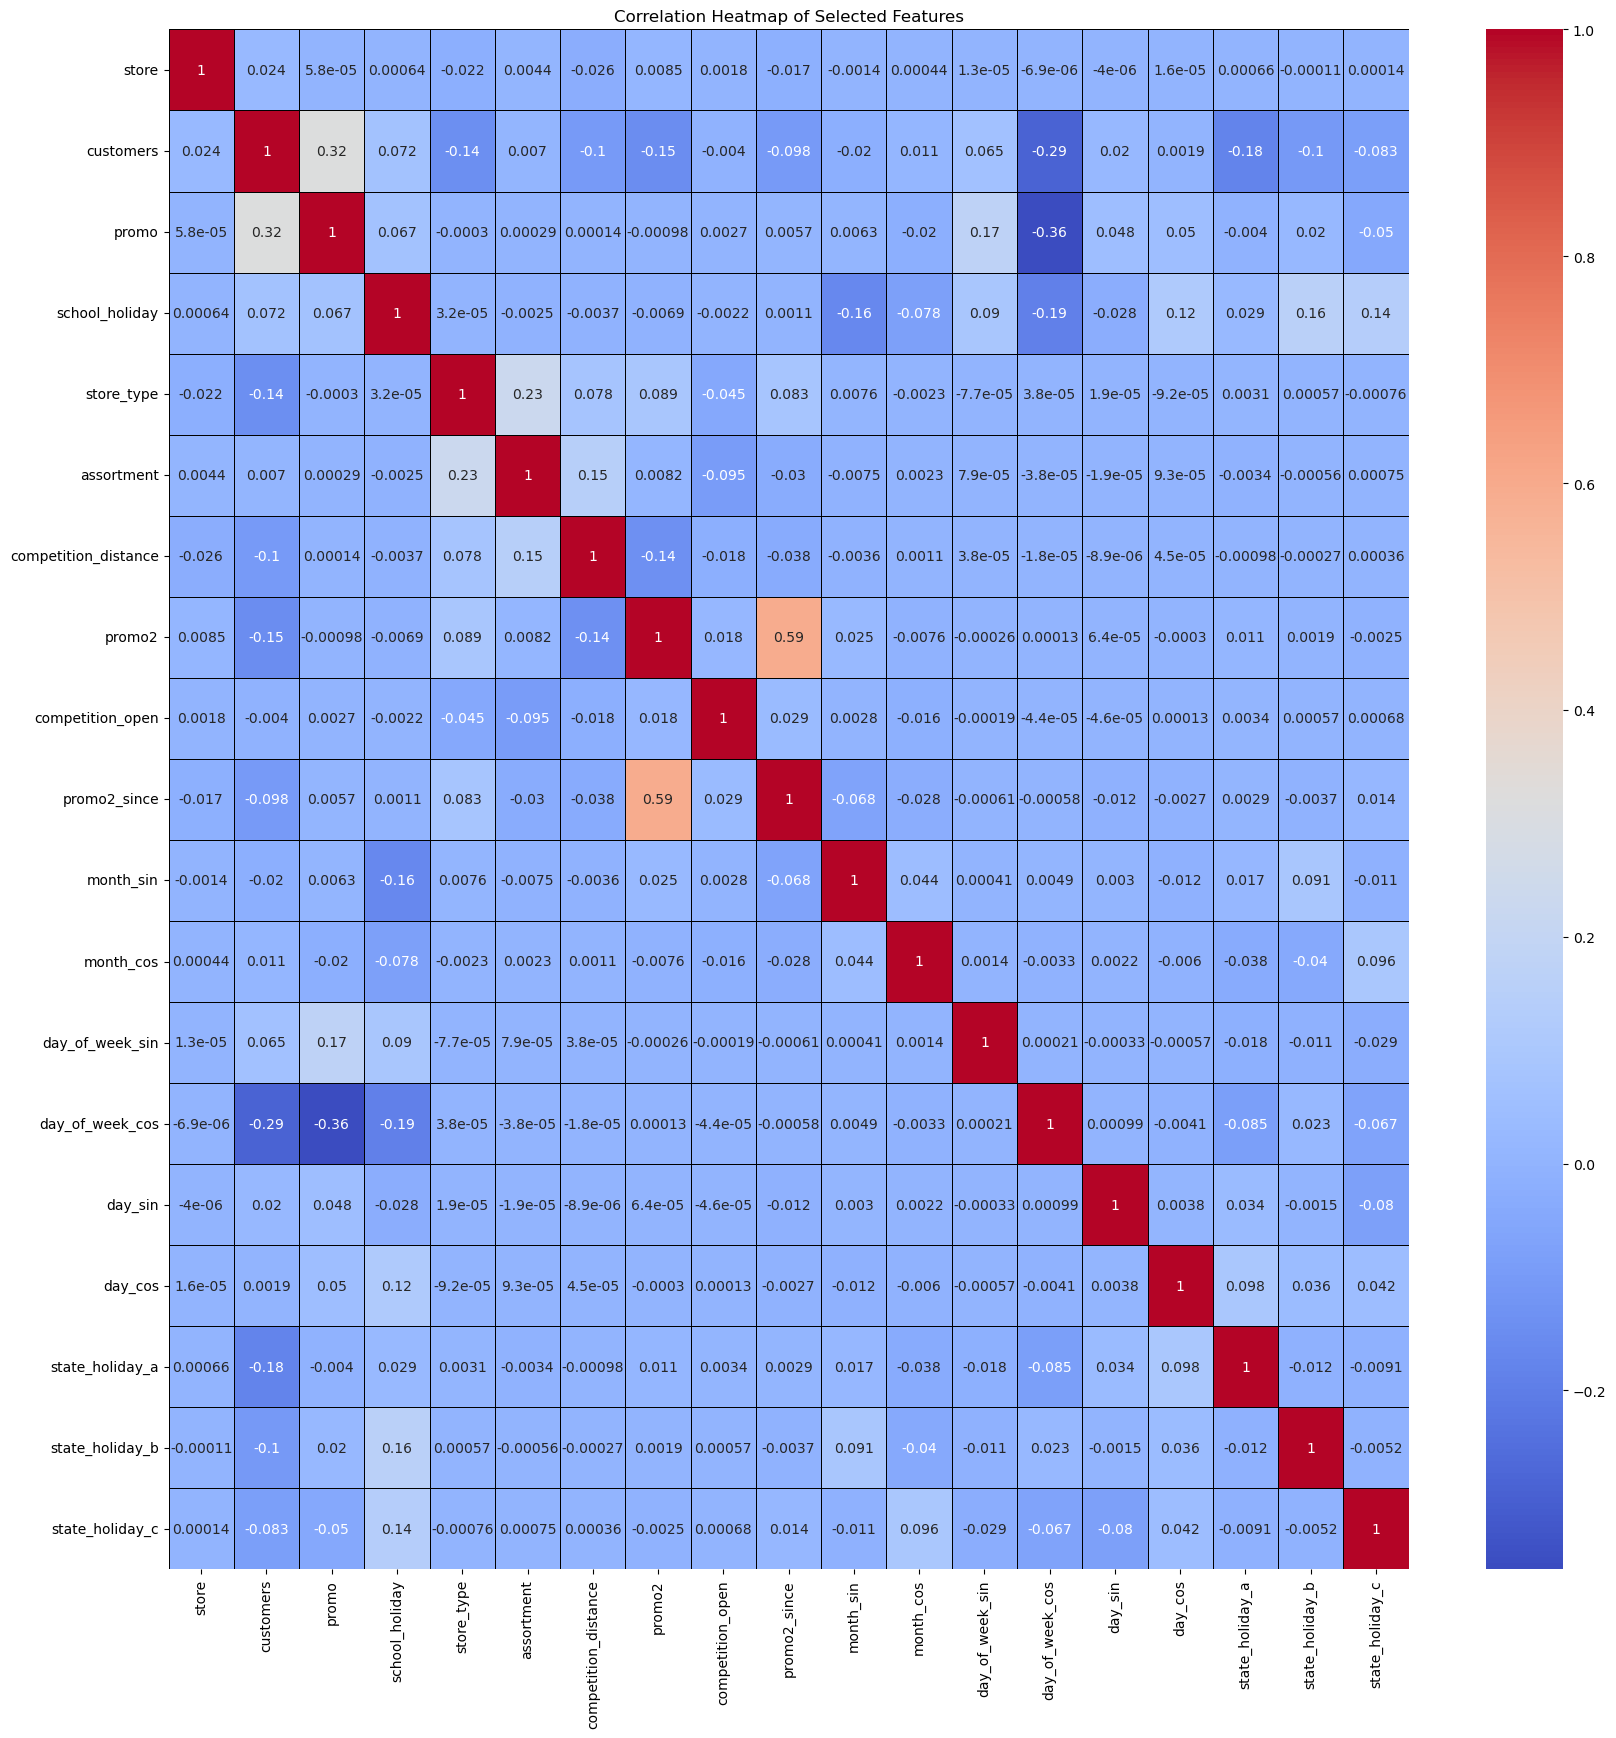

In [208]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the correlation matrix
correlation_matrix = X_selectkbest.corr()

# Plot the heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, linecolor='black')
plt.title('Correlation Heatmap of Selected Features')
plt.show()